In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import HeatMap
import scipy
from scipy import stats
from matplotlib import pyplot as plt

   # Creating Classes

   **Road data handling class**

In [2]:
class Road_Features():
    """
    This class reads the csvs of Road data , clean and returen the organized dataFrames
    """
    def __init__(self,weather):
        self.weather=weather
        self.Signal_Handling()
        self.Speed_Handling()
        self.Camera_Handling()
        self.Incidents_Handling()
        self.Sign_Handling()
        self.Volume_Handling()
        

    def Speed_Handling(self):
        """
        This function reads the speed csv file and splits/filters the data
        """
        self.speed_limit=pd.read_csv('Speed_Limits.csv')
        
        self.speed_limit.rename(columns={'STREET_NAME':'Location','SPEED':'Speed','multiline':'Coordinates','CREATED_DT':'Date'},inplace=True)
        coord=self.speed_limit['Coordinates'].str.split(expand=True)
        
        for i in range(len(coord.columns)):
            if(i>0):
                coord[i]= coord[i].str.strip(')(,')
        coord.drop(columns=0,inplace=True)
        self.speed_limit['Date']=pd.to_datetime(self.speed_limit['Date'])
        self.speed_limit['Year']=pd.DatetimeIndex(self.speed_limit['Date']).year
        
        self.speed_limit=self.speed_limit[['Year','Speed']]
        self.speed_limit=pd.merge(self.speed_limit,coord,left_index=True,right_index=True)
        self.speed_limit=self.speed_limit.loc[self.speed_limit['Year']<=2018]
    def Camera_Handling(self):
        """
        This function reads the Camera csv file and splits/filters the data
        """
        self.cameras=pd.read_csv('Traffic_Camera_Locations.csv')
        self.cameras=self.cameras[['longitude','latitude']]
    def Incidents_Handling(self):
        """
        This function reads the Incident Csv and finds the weather/visibility
        during the incident by extracting it from self.weather data frame
        organize the data 
        """
        self.incidents=pd.read_csv('Traffic_Incidents.csv')
        self.incidents.rename(columns={'INCIDENT INFO':'Location','START_DT':'Date'},inplace=True)
        self.incidents['Date']=pd.to_datetime(self.incidents['Date'])
        self.incidents['Year']=pd.DatetimeIndex(self.incidents['Date']).year
        self.incidents['Day']=pd.DatetimeIndex(self.incidents['Date']).day
        self.incidents['Month']=pd.DatetimeIndex(self.incidents['Date']).month
        self.incidents['Day']=self.incidents['Day'].astype(int)
        self.incidents['Month']=self.incidents['Month'].astype(int)
        self.incidents=self.incidents[['Location','Year','Longitude','Latitude','Count','Day','Month']]
        self.incidents=self.incidents.loc[self.incidents['Year']==2018]
        self.incidents['Temp (C)']=-1
        self.incidents['Visibility (km)']=-1
        for index,row in self.incidents.iterrows():
            self.incidents.at[index,'Temp (C)']=self.weather.loc[(self.weather['Month']==row['Month']) & (self.weather['Day']==row['Day'] )]['Temp (C)']
            self.incidents.at[index,'Visibility (km)']=self.weather.loc[(self.weather['Month']==row['Month']) & (self.weather['Day']==row['Day'] )]['Visibility (km)']
            
        self.incidents=self.incidents[['Location','Year','Longitude','Latitude','Count','Temp (C)','Visibility (km)']]
        self.incidents=self.incidents.groupby('Location').sum().reset_index()
        self.incidents['Longitude']=self.incidents['Longitude']/self.incidents['Count']
        self.incidents['Latitude']=self.incidents['Latitude']/self.incidents['Count']
        self.incidents['Year']=self.incidents['Year']/self.incidents['Count']
        self.incidents['Temp (C)']=self.incidents['Temp (C)']/self.incidents['Count']
        self.incidents['Visibility (km)']=self.incidents['Visibility (km)']/self.incidents['Count']
        
       
    def Signal_Handling(self):
        """
        This function reads the Signal Csv and organize/filter data
        """
        self.signals=pd.read_csv('Traffic_Signals.csv')
        self.signals.rename(columns={'INSTDATE':'Date','INT_TYPE':'Signal Type','latitude':'Latitude',\
                                     'longitude':'Longitude'},inplace=True)
        self.signals['Intersection']=self.signals['FIRSTROAD']+' & '+self.signals['SECONDROAD']
        self.signals['Date']=pd.to_datetime(self.signals['Date'])
        self.signals['Year']=pd.DatetimeIndex(self.signals['Date']).year
        self.signals['Signal Type']=self.signals['Signal Type'].astype(str)
        self.signals=self.signals[['Intersection','Signal Type','Year','Longitude','Latitude','Count']]
        
        self.signals=self.signals.loc[self.signals['Year']<=2018]
        self.signals=self.signals.groupby('Intersection').sum().reset_index()
        
        self.signals['Longitude']=self.signals['Longitude']/self.signals['Count']
        self.signals['Latitude']=self.signals['Latitude']/self.signals['Count'] 
        self.signals['Year']=self.signals['Year']/self.signals['Count'] 
        
    def Sign_Handling(self):
        """
        This function reads the Sign Csv and organize/filter data
        """
        self.signs=pd.read_csv('Traffic_Signs.csv')
        self.signs.rename(columns={'BLADE_TYPE':'Type','INSTDATE':'Date'},inplace=True)
        
        self.signs['Date']=pd.to_datetime(self.signs['Date'])
        self.signs['Year']=pd.DatetimeIndex(self.signs['Date']).year
        self.signs['Count']=1
        self.signs=self.signs[['Type','Year','POINT','Count']]
        self.signs=self.signs.loc[(self.signs['Type']=='Pedestrian') | (self.signs['Type']=='Yield') | (self.signs['Type']=='Stop') | (self.signs['Type']=='Bicycle / Pathway') | (self.signs['Type']=='Speed') | (self.signs['Type']=='School') | (self.signs['Type']=='Playground')]
        self.signs=self.signs.groupby('POINT').sum().reset_index()
        self.signs['Year']=self.signs['Year']/self.signs['Count']
        self.signs=self.signs.loc[self.signs['Year']<=2018]
        coord=self.signs['POINT'].str.split(expand=True)
#         
        for i in range(len(coord.columns)):
            
            if (i>0):
                coord[i]= coord[i].str.strip(',()')

        coord.drop(columns=0,inplace=True)
        self.signs.drop(columns='POINT',inplace=True)
        self.signs=pd.merge(self.signs,coord,left_index=True,right_index=True)

    def Volume_Handling(self):
        """
        This function reads the Volume Csv and organize/filter data
        """
        self.volume=pd.read_csv('Traffic_Volumes_for_2018.csv')
        self.volume.rename(columns={'YEAR':'Year','SECNAME':'Location','VOLUME':'Volume'},inplace=True)
        coord=self.volume['multilinestring'].str.split(expand=True)
        for i in range(len(coord.columns)):
            
            if (i>0):
                coord[i]= coord[i].str.strip(',()')
        coord.drop(columns=0,inplace=True)
        self.volume=self.volume[['Year','Location','Volume']]
        self.volume=pd.merge(self.volume,coord,left_index=True,right_index=True)
   ## getter functions 
    def get_Speed(self):
        return self.speed_limit
    def get_Camera(self):
        return self.cameras
    def get_Incident(self):
        return self.incidents
    def get_Signal (self):
        return self.signals
    def get_Sign (self):
        return self.signs
    def get_Volume(self):
        return self.volume
        

**Weather data Class**

In [3]:
class Weather_Features():
    """
    This class reads the data from climate.weather.gc.ca and extracets the hourly
    Temp/Visibility for the year 2018
    then converts it to daily
    """
        
    def download_weather_data(self):
        self.url_template = "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station}&Year={year}&Month={month}&Day=14&timeframe={timeframe}&submit=Download+Data"
        self.daily_avg=pd.DataFrame()
        for i in range (1,13):
            self.url = self.url_template.format(station = 50430, year=2018, month=i, timeframe = 1)
            self.weather_data = pd.read_csv(self.url, index_col='Date/Time', parse_dates=True)
            self.weather_data.columns = [col.replace('\xb0', '') for col in self.weather_data.columns]
            self.data_df = pd.DataFrame(self.weather_data)
            self.data_df = self.data_df[['Month','Day','Temp (C)','Visibility (km)']]
            self.data_df=self.data_df.resample('D').mean()
            self.daily_avg=self.daily_avg.append(self.data_df)
        return self.daily_avg
    #Getter Function
    def get_Stats(self):
        return self.daily_avg.describe().reset_index()
        


**Map Class**

In [4]:
class Map ():
    """
    this class generates the map with boundary and gridlines, also generate the grid coordinates
    Todo- add markers for each grid to popup stats per grid
    """
    def __init__(self):
        """
        The constructor reads/filters boundary.csv and call other functions in Map() class
        """
        self.boundary=pd.read_csv('City_Boundary_layer.csv')
        self.boundary=self.boundary['the_geom'].str.split(expand=True)
            
        
        for i in range(len(self.boundary.columns)):
            if(i>0):
                self.boundary[i]= self.boundary[i].str.strip(')(,')
        self.boundary.drop(columns=0,inplace=True)
        self.Boundary()
        self.draw_Boundary()
        self.draw_Grid()
        self.generate_Grid_Coord()
        
    def Boundary(self):
        """
        This function grabs the max/min latitude and longitude from the dataframe generated
        in the constructor
        
        """
       
        df=pd.DataFrame(columns=['Lat','Long'])
        for i in range(0,len(self.boundary.columns),2):
            if(i+1)<len(self.boundary.columns):
                df = df.append({'Long':self.boundary.iloc[0,(i)],'Lat':self.boundary.iloc[0,(i+1)]}, ignore_index=True)
            else:
                break
        self.min_lat=float(df['Lat'].min())
        self.max_lat=float(df['Lat'].max())
        self.min_long=float(df['Long'].min())
        self.max_long=float(df['Long'].max())
    def draw_Boundary(self):
        """
        This function uses the max/min latitude and longitude to draw the boundary around city of Calgary
        """
        self.m=folium.Map(location=[51.048615,-114.070847],zoom_start=10)
        cord=[[self.min_lat,self.max_long],[self.min_lat,self.min_long],
              [self.max_lat,self.min_long],[self.max_lat,self.max_long],[self.min_lat,self.max_long]]
        
        folium.PolyLine(cord,color='blue').add_to(self.m)
        
    def draw_Grid(self):
        """
        This Function draws the 10x10 grid
        """
        self.diff_long=(self.max_long-self.min_long)/10
        
        self.diff_lat=(self.max_lat-self.min_lat)/10
        for i in range(10):
            cord=[[self.min_lat,(self.max_long-self.diff_long*i)],[self.max_lat,(self.max_long-self.diff_long*i)]]
            line=folium.vector_layers.PolyLine(cord,color='blue').add_to(self.m)
        for i in range(10):
            cord=[[(self.max_lat-self.diff_lat*i),self.max_long],[(self.max_lat-self.diff_lat*i),self.min_long]]
            line=folium.vector_layers.PolyLine(cord,color='blue').add_to(self.m)
        
    def generate_Grid_Coord(self):
        """
        This function generates the grid coordinates for all the 10x10 grid
        and store it in a dataframe
        """
        self.grid_coord=pd.DataFrame(index=['max_lat','min_lat','max_long','min_long'])
        count=0
        key=1
        while(count<=9):
            for i in range(10):
                max_lat=(self.max_lat-self.diff_lat*count)
                min_lat=(self.max_lat-self.diff_lat*(count+1))
                max_long=(self.max_long-self.diff_long*i)
                min_long=(self.max_long-self.diff_long*(i+1))
                
                self.grid_coord[key]=[max_lat,min_lat,max_long,min_long]
        
        
                key+=1
            count+=1
        self.m.save('index.html')
    
    
    #Getter functions
    def get_Grid_Coord(self):
        return self.grid_coord
    def get_map(self):
        return self.m
        



**Data Analysis Class**

In [5]:
class Data_Analysis():
    """
    This class will find if any of the data fall in the grid
    and calculate the stats
    """
    def __init__(self,speed,camera,incident,signal,sign,volume,grid_coord):
        self.speed=speed
        self.camera=camera
        self.incident=incident
        self.signal=signal
        self.sign=sign
        self.volume=volume
        self.grid_coord=grid_coord
        ## calling functions
        self.sign_Analysis()
        self.signal_Analysis()
        self.incident_Analysis()
        self.camera_Analysis()
        self.volume_Analysis()
        self.speed_Analysis()
        self.speed_Coordinates()
        self.merge_Data()

    def speed_Coordinates(self):
        """
        This function combines all the lat/long per speed in the self.speed dataframe
        inorder to draw the speed map
        """
        self.speed_cord=pd.DataFrame(columns=['Speed','Coord'])
        for index,row in self.speed.iterrows():
            temp=[[]]
            for i in range(3,len(self.speed.columns)-1,2):
                if( row[i]!=None):
                    long=float(row[i])
                    lat=float(row[i+1])
                    temp.append([lat,long])
            temp.pop(0)
            self.speed_cord=self.speed_cord.append({'Speed':row['Speed'],'Coord':temp},ignore_index=True)
                   
        
    def speed_Analysis(self):
        """
        This function finds the average speed per grid by using three for loops
        1st loop to iterate through dataframe rows
        2nd loop to iterate through datframe columns
        3rd loop to iterate through all the grid coordinates
        find the speed in each grid then average speed per grid
        """
        self.speed_per_grid=pd.DataFrame(columns=['Speed','Grid_Location'])
       
        
        for index,row in self.speed.iterrows():
            for i in range(1,len(self.speed.columns)-1,2):
                if( row[i]!=None):
                    long=float(row[i])
                    lat=float(row[i+1])
                   
                    for k in range(1,len(self.grid_coord.columns)):
                        max_lat=float(self.grid_coord.iloc[0,k])
                        min_lat=float(self.grid_coord.iloc[1,k])
                        max_long=float(self.grid_coord.iloc[2,k])
                        min_long=float(self.grid_coord.iloc[3,k])
                        #NOTE: long logic is in reverse
                        if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                            self.speed_per_grid=self.speed_per_grid.append({'Speed':row['Speed'],'Grid_Location':k},ignore_index=True)
                else:
                    continue
        self.speed_per_grid=self.speed_per_grid.astype(int)
        self.speed_per_grid=self.speed_per_grid.groupby('Grid_Location').mean().reset_index()
        
    def volume_Analysis(self):
        """
        This function finds the volume speed per grid by using three for loops
        1st loop to iterate through dataframe rows
        2nd loop to iterate through datframe columns
        3rd loop to iterate through all the grid coordinates
        find the volume in each grid then average volume per grid
        """
        self.volume_per_grid=pd.DataFrame(columns=['Volume','Grid_Location'])
       
        for index,row in self.volume.iterrows():
            
            for i in range(1,len(self.volume.columns)-2,2):#-2 because we have one more addition col in volume df
                if( row[i]!=None):
                    long=float(row[i])
                    lat=float(row[i+1])
                    for k in range(1,len(self.grid_coord.columns)):
                        max_lat=float(self.grid_coord.iloc[0,k])
                        min_lat=float(self.grid_coord.iloc[1,k])
                        max_long=float(self.grid_coord.iloc[2,k])
                        min_long=float(self.grid_coord.iloc[3,k])
                        #NOTE: long logic is in reverse
                        if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                            self.volume_per_grid=self.volume_per_grid.append({'Volume':row['Volume'],'Grid_Location':k},ignore_index=True)
                else:
                    continue
        self.volume_per_grid=self.volume_per_grid.astype(int)
        self.volume_per_grid=self.volume_per_grid.groupby('Grid_Location').mean().reset_index()
    def camera_Analysis (self):
        """
        This function counts the number of camera per grid
        """
        self.camera_per_grid=pd.DataFrame(columns=['Camera','Grid_Location'])
        for index,row in self.camera.iterrows():
            long=float(row['longitude'])
            lat=float(row['latitude'])
            for k in range(1,len(self.grid_coord.columns)):
                max_lat=float(self.grid_coord.iloc[0,k])
                min_lat=float(self.grid_coord.iloc[1,k])
                max_long=float(self.grid_coord.iloc[2,k]) 
                min_long=float(self.grid_coord.iloc[3,k])
                if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                    self.camera_per_grid=self.camera_per_grid.append({'Camera':1,'Grid_Location':k},ignore_index=True)
            
        self.camera_per_grid=self.camera_per_grid.astype(int)
        self.camera_per_grid=self.camera_per_grid.groupby('Grid_Location').sum().reset_index()
    def incident_Analysis(self):
        """
        This function finds the avergae incident per grid and the average temp(C) /Visibility (km) per grid
        """
        self.incident_per_grid=pd.DataFrame(columns=['Incident','Grid_Location','Temp (C)','Visibility (km)'])
        for index,row in self.incident.iterrows():
            long=float(row['Longitude'])
            lat=float(row['Latitude'])
            for k in range(1,len(self.grid_coord.columns)):
                max_lat=float(self.grid_coord.iloc[0,k])
                min_lat=float(self.grid_coord.iloc[1,k])
                max_long=float(self.grid_coord.iloc[2,k]) 
                min_long=float(self.grid_coord.iloc[3,k])
                if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                    self.incident_per_grid=self.incident_per_grid.append({'Incident':row['Count'],'Grid_Location':k,'Temp (C)':row['Temp (C)'],'Visibility (km)':row['Visibility (km)']},ignore_index=True)
        self.incident_per_grid=self.incident_per_grid.astype(int)
        self.incident_per_grid=self.incident_per_grid.groupby('Grid_Location').mean().reset_index()
        print(self.incident_per_grid)
    def signal_Analysis(self):
        """
        This function finds the number of signals per grid
        """
        self.signal_per_grid=pd.DataFrame(columns=['Signal','Grid_Location'])
        for index,row in self.signal.iterrows():
            long=float(row['Longitude'])
            lat=float(row['Latitude'])
            for k in range(1,len(self.grid_coord.columns)):
                max_lat=float(self.grid_coord.iloc[0,k])
                min_lat=float(self.grid_coord.iloc[1,k])
                max_long=float(self.grid_coord.iloc[2,k]) 
                min_long=float(self.grid_coord.iloc[3,k])
                if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                    self.signal_per_grid=self.signal_per_grid.append({'Signal':row['Count'],'Grid_Location':k},ignore_index=True)
        self.signal_per_grid=self.signal_per_grid.astype(int)
        self.signal_per_grid=self.signal_per_grid.groupby('Grid_Location').sum().reset_index()
    def sign_Analysis(self):
        """
        This function finds the number of signs per grid
        """
        self.sign_per_grid=pd.DataFrame(columns=['Sign','Grid_Location'])
        for index,row in self.sign.iterrows():
            long=float(row[1])
            lat=float(row[2])
            for k in range(1,len(self.grid_coord.columns)):
                max_lat=float(self.grid_coord.iloc[0,k])
                min_lat=float(self.grid_coord.iloc[1,k])
                max_long=float(self.grid_coord.iloc[2,k]) 
                min_long=float(self.grid_coord.iloc[3,k])
                if(min_lat<lat and lat<max_lat) and (max_long<long and long<min_long):
                    self.sign_per_grid=self.sign_per_grid.append({'Sign':row['Count'],'Grid_Location':k},ignore_index=True)
        self.sign_per_grid=self.sign_per_grid.astype(int)
        self.sign_per_grid=self.sign_per_grid.groupby('Grid_Location').sum().reset_index()
    def merge_Data(self):
        """
        This function merges all of the generated dataframe from the above functions
        """
        ##merged camera & signal
        df1=pd.merge(self.camera_per_grid,self.signal_per_grid,how='outer',on=['Grid_Location'])
        ## merged speed & volume
        df2=pd.merge(self.speed_per_grid,self.volume_per_grid,how='outer',on=['Grid_Location'])
        ## merged incident & sign
        df3=pd.merge(self.incident_per_grid,self.sign_per_grid,how='outer',on=['Grid_Location'])
        ## mege df1 and df2
        df4=pd.merge(df1,df2,how='outer',on=['Grid_Location'])
        ## final merge df4 and df 3
        self.stats_per_grid=pd.merge(df4,df3,how='outer',on=['Grid_Location'])
    # getter functions    
    def get_Stats_per_Grid(self):
        return self.stats_per_grid
    def get_Speed_Coord (self):
        return self.speed_cord
        
        
        
        


**Data Visualization Class**

In [27]:
class Visualize():
    """
    This class generates the stats per grid map, speed map, and heat map
    """
    def __init__(self,map,data,speed_cord,volume,grid_coord):
        self.map=map
        self.data=data
        self.speed_cord=speed_cord
        self.volume=volume
        self.grid_coord=grid_coord
        self.draw_Speed_Map()
        self.heat_map()
        self.draw_Stats_Map()
    def draw_Stats_Map(self):
        """
        This function generats the stats per grid map
        """
        for index,row in self.data.iterrows():
            max_lat=float(self.grid_coord.iloc[0,int(row['Grid_Location'])])
            min_lat=float(self.grid_coord.iloc[1,int(row['Grid_Location'])])
            min_long=float(self.grid_coord.iloc[2,int(row['Grid_Location'])]) 
            max_long=float(self.grid_coord.iloc[3,int(row['Grid_Location'])])
            folium.Marker(location=[((max_lat+min_lat)/2),((min_long+max_long)/2)],tooltip="Camera: {} \n Signal: {} \n Speed: {} \n Volume: {} \n Incident: {} \n Sign: {} \n Temp: {} \n Visibility: {}".format(row['Camera'],row['Signal'],row['Speed'],row['Volume'],row['Incident'],row['Sign'],row['Temp (C)'],row['Visibility (km)']),radius=10).add_to(self.map)
        self.map.save('stats_per_grid.html')
    def draw_Speed_Map(self):
        """
        This function generates the Speed Map
        """
        self.speed_Map=folium.Map(location=[51.048615,-114.070847],zoom_start=10)
        
        lis=list(self.speed_cord['Speed'].unique())
        lgd_txt = '<span style="color: {col};">{txt}</span>'
        color=['gray', 'blue', 'green', 'purple', 'orange', 'darkred', 'yellow', 'beige','red','pink','black']
        combo={}
        list_groups={}
        for i in range(len(lis)):
            f=folium.FeatureGroup(name= lgd_txt.format( txt= lis[i], col= color[i]))
            list_groups[lis[i]]=f
            combo[lis[i]]=color[i]
        for index,row in self.speed_cord.iterrows():
            line=folium.vector_layers.PolyLine(row['Coord'],color=combo[row['Speed']]).add_to(list_groups[row['Speed']] )
        for key in list_groups:
            list_groups[key].add_to(self.speed_Map)
        folium.LayerControl().add_to(self.speed_Map)
      
        self.speed_Map.save('Speed_Map.html')
    def heat_map(self):
        """
        generates the heat map
        """
        self.heat_map = folium.Map(location=[51.048615,-114.070847],zoom_start = 13) 

        # Ensure you're handing it floats
        self.volume[1] = self.volume[1].astype(float)
        self.volume[2] = self.volume[2].astype(float)
        self.volume['Volume'] = self.volume['Volume'].astype(float)
        self.volume['Volume']= self.volume['Volume']/self.volume['Volume'].mean()
        # Filter the DF for rows, then columns, then remove NaNs
        heat_df = self.volume[[2,1,'Volume']]
        # List comprehension to make out list of lists
        heat_data = [[row[2], row[1],row['Volume']] for index, row in heat_df.iterrows()]

        # Plot it on the map
        folium.plugins.HeatMap(heat_data, radius = 30).add_to(self.heat_map)
        self.heat_map.save('heat_map.html')
    #Getter Functions     
    def get_heatMap(self):
        return self.heat_map
    def get_SpeedMap(self):
        return self.speed_Map
    def get_StatsMap(self):
        return self.map
        
            


**Main Code**

In [7]:
weather=Weather_Features().download_weather_data()
road=Road_Features(weather)
speed=road.get_Speed()
camera=road.get_Camera()
incident=road.get_Incident()
signal=road.get_Signal()
sign=road.get_Sign()
volume=road.get_Volume()


In [8]:
map=Map()

In [9]:
m=map.get_map()

In [10]:
grid_coord=map.get_Grid_Coord()


In [11]:
dataAnalysis=Data_Analysis(speed,camera,incident,signal,sign,volume,grid_coord)

    Grid_Location  Incident  Temp (C)  Visibility (km)
0               3  1.100000  0.500000        30.600000
1               4  2.000000  7.000000        15.000000
2               5  1.000000  9.800000        35.800000
3               6  1.437500  2.375000        24.187500
4               7  1.266667 -2.733333        24.666667
..            ...       ...       ...              ...
65             88  1.275862  3.275862        28.758621
66             89  1.000000  9.000000        37.000000
67             95  1.400000  4.000000        31.600000
68             96  1.416667  0.833333        24.666667
69             97  1.000000  5.166667        25.250000

[70 rows x 4 columns]


In [12]:
stats_per_grid=dataAnalysis.get_Stats_per_Grid()
stats_per_grid=stats_per_grid.replace(np.NaN,0)
speed_cord=dataAnalysis.get_Speed_Coord()


In [35]:
stats_per_grid = stats_per_grid.sort_values('Incident',ascending=False)
stats_per_grid

,Grid_Location,Camera,Signal,Speed,Volume,Incident,Temp (C),Visibility (km),Sign
18,46,5.0,33.0,77.162954,48142.142857,2.279503,3.608696,28.049689,1091.0
20,54,3.0,27.0,40.790598,41029.411765,2.237037,2.355556,26.029630,1663.0
58,4,0.0,0.0,60.000000,1961.206897,2.000000,7.000000,15.000000,196.0
12,36,6.0,35.0,64.567757,37966.824645,1.966480,2.994413,28.201117,432.0
22,56,5.0,19.0,76.485788,47646.044625,1.947368,3.203947,26.657895,380.0
...,...,...,...,...,...,...,...,...,...
77,19,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
78,20,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8.0
79,39,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
80,98,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.0


In [28]:
draw_stats=Visualize(m,stats_per_grid,speed_cord,volume,grid_coord)

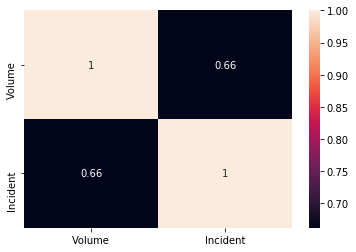

In [15]:
corr = stats_per_grid[['Volume','Incident']].corr()
sns.heatmap(corr, annot =True)


**Spearman Correlation between grid data**

In [16]:
temp = stats_per_grid.corr(method='spearman')
temp

,Grid_Location,Camera,Signal,Speed,Volume,Incident,Temp (C),Visibility (km),Sign
Grid_Location,1.000000,0.095359,0.013270,-0.147166,-0.213243,-0.006741,0.015991,0.074627,0.004299
Camera,0.095359,1.000000,0.790989,0.033679,0.479390,0.435741,0.283975,0.367334,0.697308
Signal,0.013270,0.790989,1.000000,-0.004018,0.541730,0.510779,0.315906,0.458905,0.918836
Speed,-0.147166,0.033679,-0.004018,1.000000,0.289051,0.267016,0.112880,0.158371,-0.069820
Volume,-0.213243,0.479390,0.541730,0.289051,1.000000,0.597935,0.168030,0.222902,0.482444
Incident,-0.006741,0.435741,0.510779,0.267016,0.597935,1.000000,0.286943,0.225630,0.456521
Temp (C),0.015991,0.283975,0.315906,0.112880,0.168030,0.286943,1.000000,0.441909,0.339060
Visibility (km),0.074627,0.367334,0.458905,0.158371,0.222902,0.225630,0.441909,1.000000,0.505617
Sign,0.004299,0.697308,0.918836,-0.069820,0.482444,0.456521,0.339060,0.505617,1.000000


## Data interpretation 

**Plot 1: The number of incidents vs the number of Cameras**

This plot shows us the relation between the total number of cameras and the average number of incidents that occured in the City of Calgary. Clearly the data shows as the number of camera increases, the average number of incidents decreases.

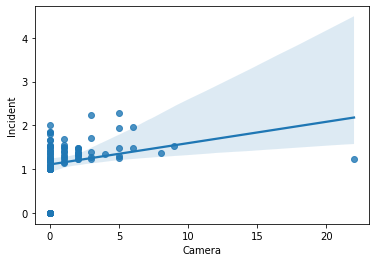

In [22]:
sns.regplot(x="Camera", y="Incident", data=stats_per_grid)

**Plot 2: The average number of incidents vs volume of cars**
    
This plot shows us the relation between the volume of cars and the average number of incidents that occured in the City of Calgary. We can observe from the data that the number of cars has a direct affect on the number of incidents on the road. 

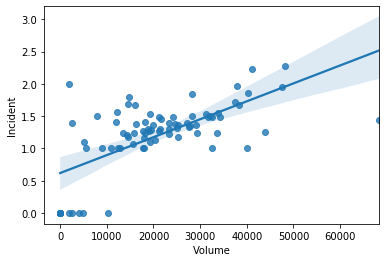

In [23]:
sns.regplot(x="Volume", y="Incident", data=stats_per_grid)

**Plot 3: The average number of incidents vs speed**

This plot shows us the relation between speed and the average number of incidents that occured in the City of Calgary.
The plot shoes the positive correlation between the average number of incident and the speed. As the speed increases, the average number of incidents increases as well. 

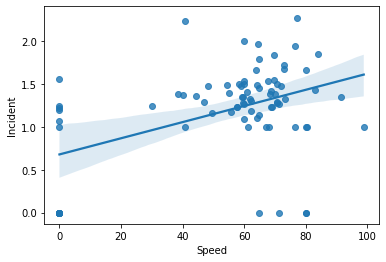

In [24]:
sns.regplot(x="Speed", y="Incident", data=stats_per_grid)

**Plot 4: The average number of incidents vs signs**

This plot shows us the relation between number of signs and the average number of incidents that occured in the City of Calgary. The data shows that the number of signs has an overall effect on the average number of incidents. The average is number of incidents is kept constants at approx 1.5 incidents in areas where there are a lot of signs.

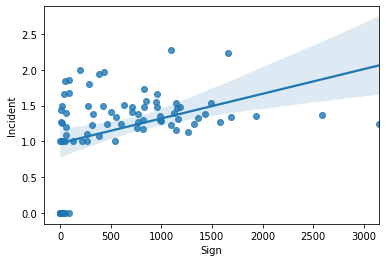

In [25]:
sns.regplot(x="Sign", y="Incident", data=stats_per_grid)

**Plot 5: The average number of incidents vs signals**

This plot shows us the relation between number of signals and the average number of incidents that occured in the City of Calgary. Signals have little effect on the number of incidents.

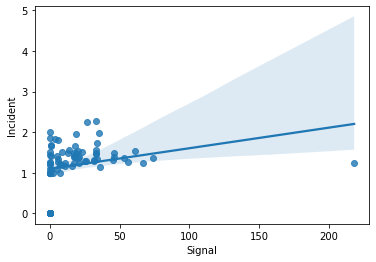

In [30]:
sns.regplot(x="Signal", y="Incident", data=stats_per_grid)

**Plot 6: The average number of incidents vs Visibility (km)**

This plot shows us the relation between Visibility (km) and the average number of incidents that occured in the City of Calgary. It can be seen that most of the Incidents happen when visibility is between 20 and 30 km

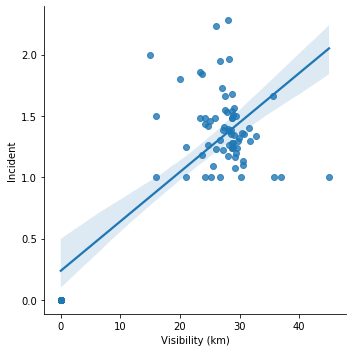

In [91]:
sns.lmplot(x='Visibility (km)', y="Incident",data=stats_per_grid)

**Plot 7: The average number of incidents vs Temp (C)**

This plot shows us the relation between Temp (C) and the average number of incidents that occured in the City of Calgary. It can be seen that most of the Incidents happen when Temp is between 0 and 5  deg C

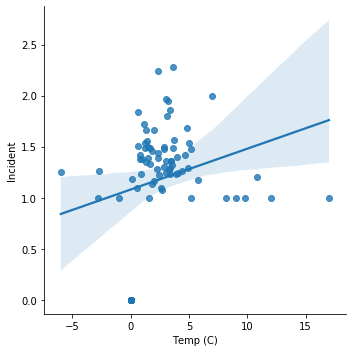

In [96]:
sns.lmplot(x='Temp (C)', y="Incident",data=stats_per_grid)

## Visualization

**Stats per grid Map**

In [97]:
m

**Speed Map**

draw_stats.get_SpeedMap()

**Heat Map**

In [99]:
draw_stats.get_heatMap()

**Conclusion**